# Import Packages

In [133]:
import math
import torch
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import torch.profiler as profiler
from tensorboardX import SummaryWriter
import datetime
import warnings
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from typing import List, Tuple
warnings.filterwarnings('ignore')

# Retreive Data

In [134]:
parquet_file = '../data/D16.04.30G04.29.21.57.49.parquet'
df_by_store = pd.read_parquet(parquet_file)
df_by_store

,date,resource_id,earnings
0,2016-04-30,1,190951.513616
1,2016-04-30,2,144322.305020
2,2016-04-30,3,82350.701090
3,2016-04-30,4,50247.541535
4,2016-04-30,5,40151.844188
...,...,...,...
0,2021-04-28,1,67535.750246
1,2021-04-28,2,77853.066217
2,2021-04-28,3,55697.330652
3,2021-04-28,4,36430.965137


In [135]:
writer = SummaryWriter('logs')

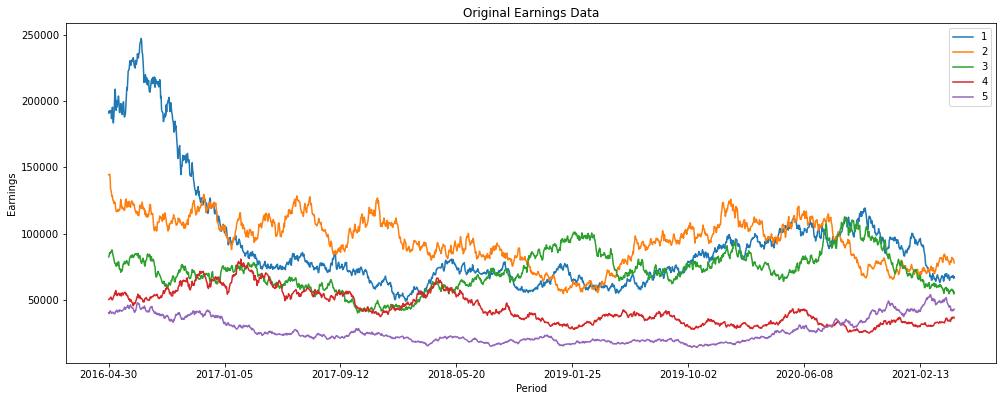

In [136]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
for key, grp in df_by_store.groupby(['resource_id']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='earnings', label=key)
leg = ax.legend()
plt.title(f'Original Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')

plt.savefig('logs/earnings_data.png')

## Start with Aggregate Data

In [137]:
# get cumulative earnings into sequence
df_stores_total_daily = df_by_store.groupby(by=['date']).sum()['earnings'].reset_index()
df_stores_total_daily.head()

,date,earnings
0,2016-04-30,508023.905450
1,2016-05-01,510143.808902
2,2016-05-02,513003.372808
3,2016-05-03,512449.496245
4,2016-05-04,504160.586534


# Regression features

In [138]:
df_stores_total_daily['Year'] = pd.to_datetime(df_stores_total_daily['date']).dt.year
df_stores_total_daily['Month'] = pd.to_datetime(df_stores_total_daily['date']).dt.month
df_stores_total_daily['WeekOfMonth'] = pd.to_datetime(df_stores_total_daily['date']).dt.day.apply(lambda day: math.ceil(int(day)/7))
df_stores_total_daily['WeekOfYear'] = pd.to_datetime(df_stores_total_daily['date']).dt.week
df_stores_total_daily['DayOfMonth'] = pd.to_datetime(df_stores_total_daily['date']).dt.day
df_stores_total_daily['DayOfYear'] = pd.to_datetime(df_stores_total_daily['date']).dt.dayofyear

df_stores_total_daily.head()

,date,earnings,Year,Month,WeekOfMonth,WeekOfYear,DayOfMonth,DayOfYear
0,2016-04-30,508023.905450,2016,4,5,17,30,121
1,2016-05-01,510143.808902,2016,5,1,17,1,122
2,2016-05-02,513003.372808,2016,5,1,18,2,123
3,2016-05-03,512449.496245,2016,5,1,18,3,124
4,2016-05-04,504160.586534,2016,5,1,18,4,125


In [139]:
# get cumulative earnings into sequence
df_stores_total_monthly = df_stores_total_daily.groupby(by=['Month','Year']).sum()['earnings'].reset_index()
df_stores_total_monthly.head()

,Month,Year,earnings
0,1,2017,1.124640e+07
1,1,2018,8.161197e+06
2,1,2019,8.439462e+06
3,1,2020,1.046836e+07
4,1,2021,9.628417e+06


Text(0.5, 0, 'Month')

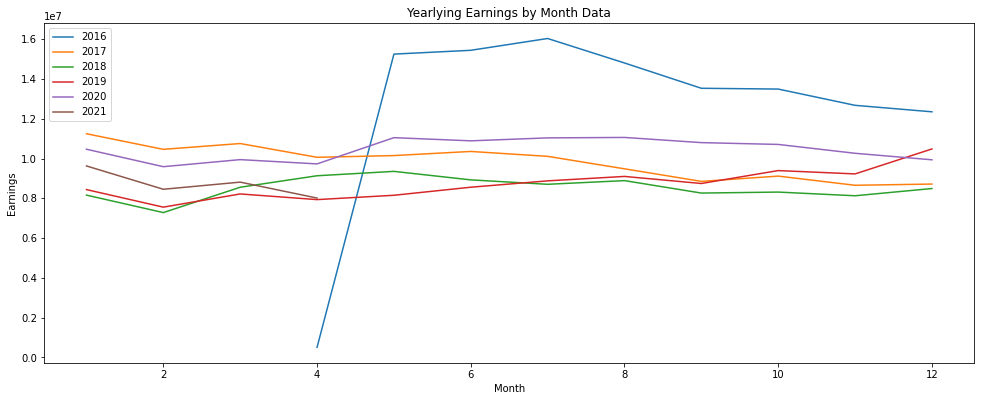

In [140]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
for key, grp in df_stores_total_monthly.groupby(['Year']):
    ax = grp.plot(ax=ax, kind='line', x='Month', y='earnings', label=key)
leg = ax.legend()
plt.title(f'Yearlying Earnings by Month Data')
plt.ylabel('Earnings')
plt.xlabel('Month')


# Cumulative Earnings Data

Text(0, 0.5, 'Earnings')

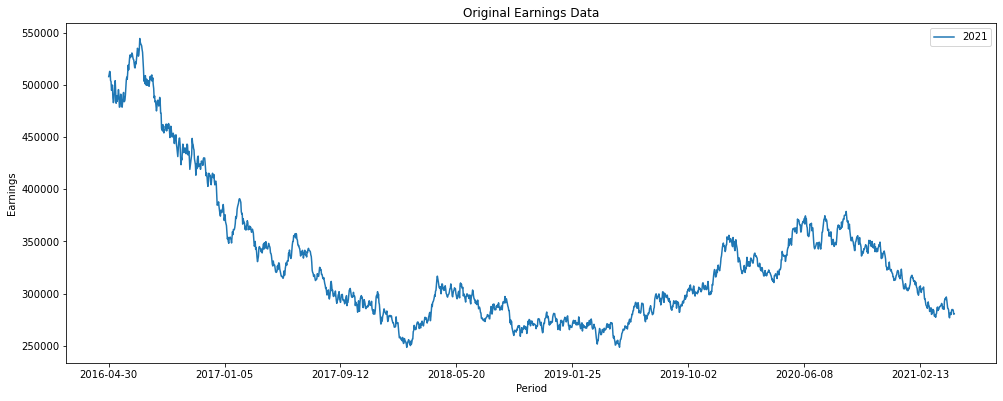

In [141]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax = df_stores_total_daily.plot(ax=ax, kind='line', x='date', y='earnings', label=key)
leg = ax.legend()
plt.title(f'Original Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')


# Split Data

In [142]:
#split data
data_all = df_stores_total_daily.earnings
sz = len(data_all)
test_sz = math.floor(.2 * sz)
sz, test_sz

(1825, 365)

In [143]:
train_data = data_all[:-test_sz]
test_data = data_all[-test_sz:]
len(train_data)+len(test_data), len(test_data)

(1825, 365)

In [144]:
msmin, msmax = train_data.min(), train_data.max()
print(f'Min: {msmin}, Max: {msmax}')
train_data_scaled = (train_data - msmin) / (msmax - msmin)

Min: 248353.75175828498, Max: 544576.2587030415


Text(0, 0.5, 'Earnings')

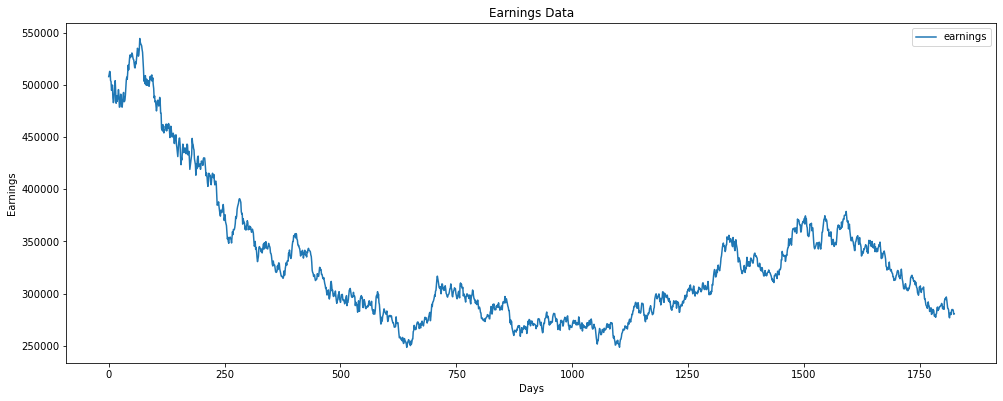

In [145]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax = data_all.plot(ax=ax, kind='line', x='days', y='earnings')
leg = ax.legend()
plt.title(f'Earnings Data')
plt.xlabel('Days')
plt.ylabel('Earnings')



# Create Dataset with Lookback

In [146]:
# lookback window
window = 100

In [147]:
class SeqDataset(Dataset):
    def __init__(self, sequence: torch.Tensor, window: int) -> None:
        self.sz = len(sequence) - window
        self.win = window
        self.seq = sequence

    def __len__(self) -> int:
        return self.sz

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.Tensor]:
        e = i + self.win
        return self.seq[i:e], self.seq[e:e+1]

    def scale(sequence: torch.Tensor, min: float, max: float) -> torch.Tensor:
        return (sequence - min) / (max - min)

    def inverse_scale(sequence: torch.Tensor, min: float, max: float) -> torch.Tensor:
        return (sequence*(max - min)) + min



In [148]:
# min/max for scaling
cmin, cmax = data_all.min(), data_all.max()
print(f'{cmin} to {cmax}')
metadata = { 
    "min": float(cmin), 
    "max": float(cmax), 
    "window": window 
}
# scale
data_all = SeqDataset.scale(data_all, cmin, cmax)
# data split
test_sz = math.floor(0.20 * len(data_all))
train_data = torch.FloatTensor(data_all[:-test_sz])
val_data = torch.FloatTensor(data_all.to_numpy()[-test_sz:])
# create sequence datasets
train_dataset = SeqDataset(train_data, window)
val_dataset = SeqDataset(val_data, window)

248353.75175828498 to 544576.2587030415


In [149]:
trainloader = DataLoader(dataset = train_dataset, batch_size = 64, num_workers= 1, shuffle = True)

# Model

In [150]:
# Model params
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [151]:
import torch
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x.view(-1, x.size(1), 1), (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    

In [152]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.to(device)

GRU(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [153]:
criterion = torch.nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA
        ],
    schedule=torch.profiler.schedule(
        wait=2,
        warmup=3,
        active=6),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./logs',"worker1"),
    record_shapes=True
) as p:
# TODO: add training loop

SyntaxError: unexpected EOF while parsing (<ipython-input-153-9a55f8062fba>, line 16)

# Model Performance

In [ ]:
def predict(seq: List[float], window: int, lookbehind: int, lookahead: int) -> List[float]:
    overlap = []
    predixn = seq[-window:]
    model.eval()
    with torch.no_grad():
        # get lookbehind period (overlap)
        for i in reversed(range(1, lookbehind+1)):
            x = torch.FloatTensor(seq[-window-i:-i]).view(1, -1).to(device)
            y = model(x)
            overlap.append(y.detach().item())
        # begin lookahead period (predictions)
        for i in range(lookahead):
            x = torch.FloatTensor(predixn[-window:]).view(1, -1).to(device)
            y = model(x)
            predixn.append(y.detach().item())
    return overlap + predixn[-lookahead:]

In [ ]:
#plot simulation
sequence = val_dataset.seq #validation sequence
# caluate lookback and forward
behind = math.floor(len(sequence) / 2)
forward = math.floor(behind / 2)
# predict
p_seq = predict(list(sequence), window, behind, forward)
# inverse scale
p_seq = SeqDataset.inverse_scale(torch.FloatTensor(p_seq), cmin, cmax)
r_seq = SeqDataset.inverse_scale(torch.FloatTensor(sequence), cmin, cmax)
# create indices
seq_size = sequence.size(0)
#print(seq_size)
actual_range = [i for i in range(seq_size)]
#print(actual_range)
pred_range = [i for i in range(seq_size-behind-1,seq_size+forward-1)]
#print(pred_range)


In [ ]:
# plot predictions over actuals
import matplotlib.ticker as tick
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax.plot(actual_range, r_seq, color='blue', label='actual')
ax.plot(pred_range, p_seq, color='red', label='predictions')
ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: '${:1.0f}K'.format(x/1000.)))
leg = ax.legend()
plt.title(f'Sequence Prediction [Back: {behind}, Forward: {forward}]')
plt.xlabel('Period')
plt.ylabel('Earnings')
# save image
plt.savefig('logs/validation_data.png', dpi=96)

In [ ]:
writer.close()